In [1]:
!pip install pydot
!pip install keras-tuner

In [2]:
# Libraries to import
import zipfile
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as ex 
import seaborn as sns
import numpy as np
import random
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Dropout, Input, Concatenate, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization

In [3]:
# Extracting 'archive.zip' file. Make sure the code and zip file are in the same folder
if not Path("orbit.csv").exists():
    
    print("Extracting zip file")
    
    # Extracting the file 
    with zipfile.ZipFile("orbit-data-for-all-known-asteroids-in-MPC-Database", 'r') as zip_ref:
        zip_ref.extractall()

    print("Finished extracting")
else:
    # If file is already present in the directory
    print("Already extracted")

Already extracted


In [4]:
# Read dataset 
raw_df = pd.read_csv("orbit.csv", low_memory = False)
raw_df

,NEO_flag,One_km_NEO_flag,PHA_flag,H,G,Num_obs,rms,U,Arc_years,Perturbers,...,Computer,Hex_flags,Last_obs,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type
0,NaN,NaN,NaN,3.53,0.15,7277.0,0.51,0,1801-2020,M-v,...,Pan,0000,2020-11-18,2.459921e+06,4.600439,2.549868,2.982310,1.374594,1.277744,MBA
1,NaN,NaN,NaN,4.21,0.15,8702.0,0.46,0,1804-2020,M-c,...,Pan,0000,2020-11-05,2.460009e+06,4.621142,2.136967,3.411796,1.313968,1.276156,MBA
2,NaN,NaN,NaN,5.26,0.15,7447.0,0.47,0,1804-2020,M-v,...,Pan,0000,2020-09-12,2.458446e+06,4.357963,1.982371,3.353669,1.245908,1.297800,MBA
3,NaN,NaN,NaN,3.29,0.15,7420.0,0.49,0,1821-2020,M-p,...,Pan,0000,2020-12-16,2.459574e+06,3.630180,2.153168,2.570893,1.171781,1.380202,MBA
4,NaN,NaN,NaN,6.99,0.15,3070.0,0.56,0,1845-2020,M-v,...,Pan,0000,2020-06-19,2.458926e+06,4.128733,2.082605,3.064637,1.239971,1.319618,MBA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048116,NaN,NaN,NaN,17.30,0.15,14.0,0.31,NaN,NaN,NaN,...,Bell,0005,2021-01-16,2.458885e+06,3.523979,1.535778,3.095691,1.026520,1.396200,Object with perihelion distance < 1.665 AU
1048117,NaN,NaN,NaN,19.70,0.15,15.0,0.13,NaN,NaN,NaN,...,Bell,0006,2021-01-18,2.458963e+06,2.465176,1.614955,2.034785,0.900362,1.682512,Hungaria
1048118,NaN,NaN,NaN,19.90,0.15,9.0,0.14,NaN,NaN,NaN,...,Bell,0006,2021-01-18,2.458928e+06,2.464443,1.645878,2.003139,0.903510,1.682853,Hungaria
1048119,NaN,NaN,NaN,19.00,0.15,16.0,0.19,NaN,NaN,NaN,...,Bell,0005,2021-01-18,2.459157e+06,4.701366,1.632723,3.980075,1.157775,1.270171,Object with perihelion distance < 1.665 AU


In [5]:
# Schema of the dataset 
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048121 entries, 0 to 1048120
Data columns (total 35 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   NEO_flag          24586 non-null    float64
 1   One_km_NEO_flag   1407 non-null     float64
 2   PHA_flag          2163 non-null     float64
 3   H                 1046851 non-null  float64
 4   G                 1046851 non-null  float64
 5   Num_obs           1048114 non-null  float64
 6   rms               1048062 non-null  float64
 7   U                 1006441 non-null  object 
 8   Arc_years         952529 non-null   object 
 9   Perturbers        1002642 non-null  object 
 10  Perturbers_2      1002642 non-null  object 
 11  Number            546846 non-null   object 
 12  Name              22153 non-null    object 
 13  Principal_desig   1048121 non-null  object 
 14  Other_desigs      74966 non-null    object 
 15  Epoch             1048121 non-null  float64
 16  

In [6]:
# Check for missing values
num_missing_values = raw_df.isnull().sum()
num_missing_values 

NEO_flag            1023535
One_km_NEO_flag     1046714
PHA_flag            1045958
H                      1270
G                      1270
Num_obs                   7
rms                      59
U                     41680
Arc_years             95592
Perturbers            45479
Perturbers_2          45479
Number               501275
Name                1025968
Principal_desig           0
Other_desigs         973155
Epoch                     0
M                         0
Peri                      0
Node                      0
i                         0
e                         0
n                         0
a                         0
Ref                       0
Num_opps                  0
Computer                  0
Hex_flags                 0
Last_obs                  0
Tp                        0
Orbital_period            0
Perihelion_dist           0
Aphelion_dist             0
Semilatus_rectum          0
Synodic_period            0
Orbit_type                0
dtype: int64

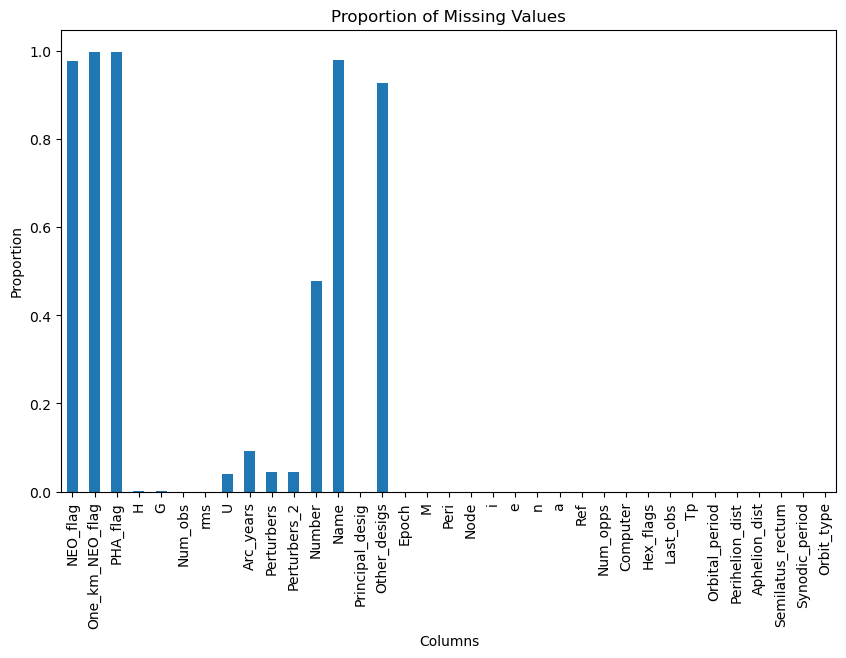

In [7]:
# Plot of proportion of missing values
# Calculate the proportion of missing values for each column
proportion_missing_values = num_missing_values / len(raw_df)

# Plot the proportion of missing values as a graph
plt.figure(figsize=(10, 6))
proportion_missing_values.plot(kind='bar')
plt.title('Proportion of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Proportion')
plt.show()

In [8]:
# Taking a look at relevant features that have high missing values 
col_missing_val = ['NEO_flag', 'One_km_NEO_flag', 'PHA_flag', 'U', 'Arc_years', 'Perturbers', 'Perturbers_2']
value_counts = {}

for column in col_missing_val:
    value_counts[column] = raw_df[column].value_counts()

for column, counts in value_counts.items():
    print(f"Value counts for {column}:")
    print(counts)
    print()

Value counts for NEO_flag:
1.0    24586
Name: NEO_flag, dtype: int64

Value counts for One_km_NEO_flag:
1.0    1407
Name: One_km_NEO_flag, dtype: int64

Value counts for PHA_flag:
1.0    2163
Name: PHA_flag, dtype: int64

Value counts for U:
0    785049
1     74430
2     56088
3     42404
4     20460
5      9925
6      6313
7      4990
E      3669
8      2189
9       719
D       196
F         9
Name: U, dtype: int64

Value counts for Arc_years:
2001-2020    39936
2000-2020    38781
2003-2020    35946
2002-2020    34552
2005-2020    31692
             ...  
1974-2016        1
  29-2020        1
1988-2013        1
1956-2013        1
1960-2008        1
Name: Arc_years, Length: 805, dtype: int64

Value counts for Perturbers:
M-v    1002341
M-h        291
M-c          6
M-N          3
M-p          1
Name: Perturbers, dtype: int64

Value counts for Perturbers_2:
38h    674711
3Ek    309486
3Eh     18432
08          6
08h         2
30k         1
28k         1
18k         1
78h         1
38j  

In [9]:
# For NEO_flag, One_km_NEO_flag, PHA_flag the missing values are simply equal to 0 as these are categorical binary variables. 
# Replace missing values as 0
flag_columns = ['NEO_flag', 'One_km_NEO_flag', 'PHA_flag']
df = raw_df
df[flag_columns] = raw_df[flag_columns].fillna(0.0)
df[flag_columns].isnull().sum()


NEO_flag           0
One_km_NEO_flag    0
PHA_flag           0
dtype: int64

In [10]:
# Column 'U' is the uncertainty parameter. 'D' values are represented as insufficient data so will impute missing values as 'D'
df['U'].fillna('D', inplace = True)
df['U'].isnull().sum()

0

In [11]:
# 'Arc_years' is feature engineered into 'Arc_length' which represents the difference between the first and last observations of when an asteroid was in opposition with Earth
df.loc[df['Arc_years'].notnull(), 'Arc_years'] = df.loc[df['Arc_years'].notnull(), 'Arc_years'].str.split('-')
df.loc[df['Arc_years'].notnull(), 'Arc_years'] = df.loc[df['Arc_years'].notnull(), 'Arc_years'].apply(lambda x: int(x[1]) - int(x[0]))

df = df.rename(columns = {'Arc_years': 'Arc_length'})

df['Arc_length'] = df['Arc_length'].astype('Int64')

In [12]:
# Investigate further on what to do with missing values in Perturbers/Perturbers_2
# Count of orbit types when Perturbers is missing
all_orbit_types_count = df['Orbit_type'].value_counts()
missing_perturbers_count = df.loc[df['Perturbers'].isnull(), 'Orbit_type'].value_counts()

# Display proportion of Orbit_types to be lost if missing values in Arc_years is omitted
print("\nProportion of Orbit_types to be lost if missing values in Arc_years is omitted")
print(missing_perturbers_count/all_orbit_types_count)

# NaN means that missing values in Perturbers don't output Atira
# Seems to be no significant correlation between missing data of Perturbers and type of orbit - can assume data is missing at random
# Will impute these values using mode after splitting into training/val/testing sets


Proportion of Orbit_types to be lost if missing values in Arc_years is omitted
Amor                                          0.009351
Apollo                                        0.010864
Aten                                          0.009549
Atira                                              NaN
Distant Object                                0.163686
Hilda                                         0.091105
Hungaria                                      0.078667
Jupiter Trojan                                0.064947
MBA                                           0.038729
Object with perihelion distance < 1.665 AU    0.209578
Phocaea                                       0.101667
Name: Orbit_type, dtype: float64


In [13]:
# Quick overview of summary statistics of the dataset 
summary = df.describe()
summary

,NEO_flag,One_km_NEO_flag,PHA_flag,H,G,Num_obs,rms,Arc_length,Epoch,M,...,e,n,a,Num_opps,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period
count,1.048121e+06,1.048121e+06,1.048121e+06,1.046851e+06,1.046851e+06,1.048114e+06,1.048062e+06,952529.0,1.048121e+06,1.048121e+06,...,1.048121e+06,1.048121e+06,1.048121e+06,1.048121e+06,1.048121e+06,1.048121e+06,1.048121e+06,1.048121e+06,1.048121e+06,1.048121e+06
mean,2.345722e-02,1.342402e-03,2.063693e-03,1.700331e+01,1.499999e-01,2.577871e+02,3.741166e-01,17.613925,2.459014e+06,1.724078e+02,...,1.560417e-01,2.361754e-01,2.870172e+00,8.470652e+00,2.458990e+06,6.400184e+00,2.391343e+00,3.349001e+00,1.370365e+00,1.387468e+00
std,1.513506e-01,3.661423e-02,4.538101e-02,1.768110e+00,7.633475e-05,4.064942e+02,1.481483e-01,10.283523,6.806149e+02,1.076891e+02,...,9.248912e-02,7.945798e-02,5.914967e+00,5.469128e+00,1.471015e+03,2.367436e+02,2.073319e+00,1.097329e+01,1.226935e+00,5.912443e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.110000e+00,9.000000e-02,2.000000e+00,0.000000e+00,0.0,2.425068e+06,0.000000e+00,...,0.000000e+00,4.660000e-06,5.554246e-01,1.000000e+00,2.342091e+06,4.139403e-01,7.072260e-02,6.537379e-01,6.934930e-02,7.063107e-01
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.620000e+01,1.500000e-01,4.900000e+01,2.600000e-01,12.0,2.459000e+06,7.567954e+01,...,9.193420e-02,1.889880e-01,2.390608e+00,4.000000e+00,2.458695e+06,3.696261e+00,1.972717e+00,2.786576e+00,1.157207e+00,1.237229e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.500000e-01,1.050000e+02,3.500000e-01,17.0,2.459200e+06,1.665122e+02,...,1.450565e-01,2.282935e-01,2.651390e+00,8.000000e+00,2.459071e+06,4.317283e+00,2.230906e+00,3.053977e+00,1.285389e+00,1.301445e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,1.780000e+01,1.500000e-01,2.670000e+02,5.000000e-01,21.0,2.459200e+06,2.673044e+02,...,2.008660e-01,2.666499e-01,3.007321e+00,1.200000e+01,2.459476e+06,5.215185e+00,2.582974e+00,3.369625e+00,1.462887e+00,1.370873e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,9.999000e+01,1.500000e-01,9.836000e+03,7.080000e+00,2020.0,2.459400e+06,3.600000e+02,...,9.987471e-01,2.381038e+00,3.549257e+03,1.180000e+02,2.546461e+06,2.114493e+05,8.036359e+01,7.094067e+03,7.037812e+01,5.015470e+03


In [14]:
# Quick overview of categorical data counts
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
value_counts = {}

for column in categorical_columns:
    value_counts[column] = df[column].value_counts()

for column, counts in value_counts.items():
    print(f"Value counts for {column}:")
    print(counts)
    print()


Value counts for U:
0    785049
1     74430
2     56088
3     42404
D     41876
4     20460
5      9925
6      6313
7      4990
E      3669
8      2189
9       719
F         9
Name: U, dtype: int64

Value counts for Perturbers:
M-v    1002341
M-h        291
M-c          6
M-N          3
M-p          1
Name: Perturbers, dtype: int64

Value counts for Perturbers_2:
38h    674711
3Ek    309486
3Eh     18432
08          6
08h         2
30k         1
28k         1
18k         1
78h         1
38j         1
Name: Perturbers_2, dtype: int64

Value counts for Number:
(1)         1
(364560)    1
(364574)    1
(364573)    1
(364572)    1
           ..
(182277)    1
(182276)    1
(182275)    1
(182274)    1
(546846)    1
Name: Number, Length: 546846, dtype: int64

Value counts for Name:
Ceres           1
Hadinger        1
Eriksorensen    1
Barbfriedman    1
Nanwoodward     1
               ..
Hanff           1
Konnai          1
Portule         1
Joya            1
Asmakhammari    1
Name: Name, Leng

In [15]:
# Multiple categories only have 1 or 2 counts which will pose a problem when splitting the data later on. Will group category frequencies less than 10 as 1 group.
columns_to_group = ['U', 'Perturbers', 'Perturbers_2', 'Computer', 'Hex_flags']
for column in columns_to_group:
    category_counts = value_counts[column]
    infrequent_categories = category_counts[category_counts <= 10].index
    df.loc[df[column].isin(infrequent_categories), column] = 'Other'

In [16]:
# Checking if this was performed correctly
value_counts = {}

for column in categorical_columns:
    value_counts[column] = df[column].value_counts()

for column, counts in value_counts.items():
    print(f"Value counts for {column}:")
    print(counts)
    print()

Value counts for U:
0        785049
1         74430
2         56088
3         42404
D         41876
4         20460
5          9925
6          6313
7          4990
E          3669
8          2189
9           719
Other         9
Name: U, dtype: int64

Value counts for Perturbers:
M-v      1002341
M-h          291
Other         10
Name: Perturbers, dtype: int64

Value counts for Perturbers_2:
38h      674711
3Ek      309486
3Eh       18432
Other        13
Name: Perturbers_2, dtype: int64

Value counts for Number:
(1)         1
(364560)    1
(364574)    1
(364573)    1
(364572)    1
           ..
(182277)    1
(182276)    1
(182275)    1
(182274)    1
(546846)    1
Name: Number, Length: 546846, dtype: int64

Value counts for Name:
Ceres           1
Hadinger        1
Eriksorensen    1
Barbfriedman    1
Nanwoodward     1
               ..
Hanff           1
Konnai          1
Portule         1
Joya            1
Asmakhammari    1
Name: Name, Length: 22153, dtype: int64

Value counts for Princi

In [17]:
# Arc_years had some erroneous data where arc_length observations were for over 1000 years. Will remove these rows.
df = df.drop(df[df['Arc_length'] > 1000].index)

In [18]:
# Reset index
df = df.reset_index(drop = True)

In [19]:
# Drop columns that are not relevant such as Name and unique identification variables etc
df = df.drop(['Name', 'Other_desigs', 'Number', 'Last_obs', 'Principal_desig', 'Ref', 'Hex_flags'], axis = 1)

# Other missing values will be imputed after splitting into training, validation and testing sets 
# Numerical values will be imputed using median (many features are heavily right-skewed from summary statistics)
# Categorical data will be imputed using mode
# These are inputed after splitting since will be training data leaks into the testing set if imputation is done first

In [20]:
# Calculate the proportion of different orbit types
class_proportion = df['Orbit_type'].value_counts(normalize=True)

# Create the pie chart using plotly.express
fig = ex.pie(class_proportion, values=class_proportion.values, names=class_proportion.index,
             labels={'names': 'Orbit Type', 'values': 'Proportion'},
             width = 1000, height = 800,
             hole = 0.33)

# Set the title
fig.update_layout(title_text='Proportion of Different Orbit Types',
                  legend = dict(font = dict(size = 14)))
fig.update_traces(textfont = dict(size = 12))

# Show the plot
fig.show()


C:\Users\brand\AppData\Local\Temp\ipykernel_12268\2995699383.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



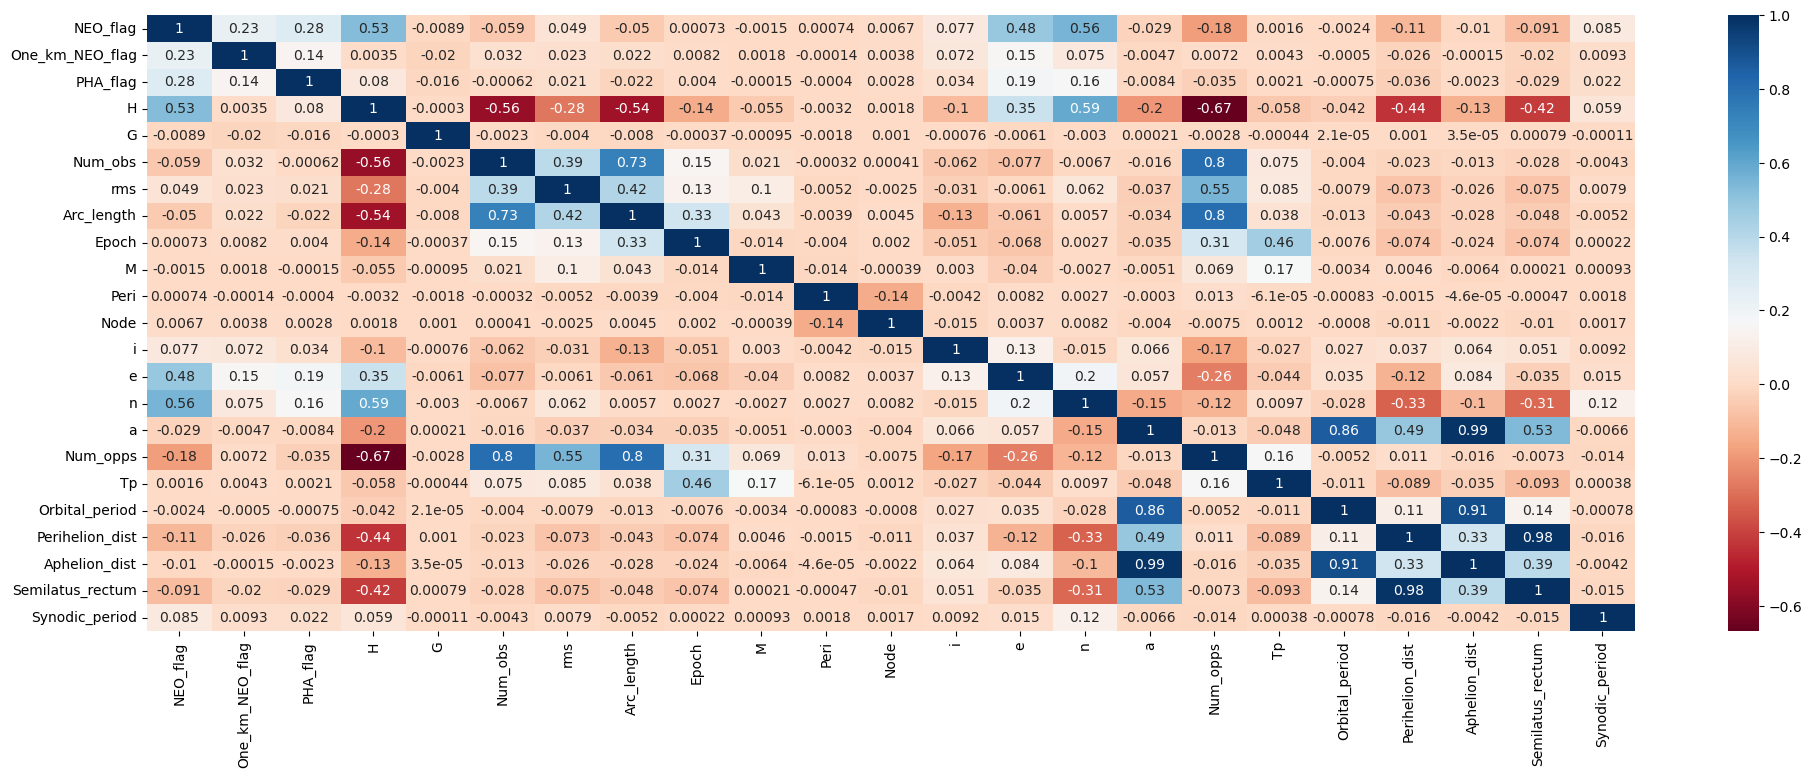

In [21]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize = (24,8))
sns.heatmap(df.corr(), cmap = "RdBu", annot = True, ax = ax)
plt.show()

# Some strong positive linear correlations show between orbital period, perihelion_dist, aphelion_dist, semilatus_rectum
# Strong negative linear correlations show between H vs Num_opps, and H vs Arc_length

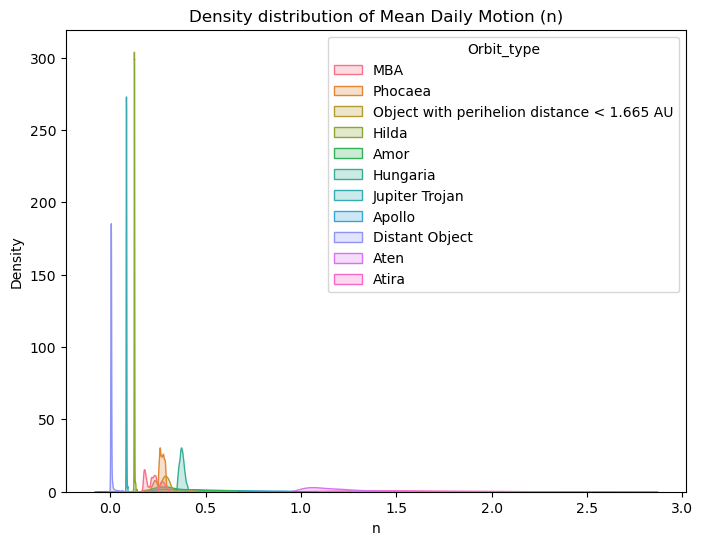

In [22]:
# Plot density of Mean Daily Motion, 'n'
plt.figure(figsize=(8,6))
dens_plot = sns.kdeplot(df, x = 'n', hue = 'Orbit_type', fill = True, common_norm = False)

plt.title("Density distribution of Mean Daily Motion (n)")

plt.show()

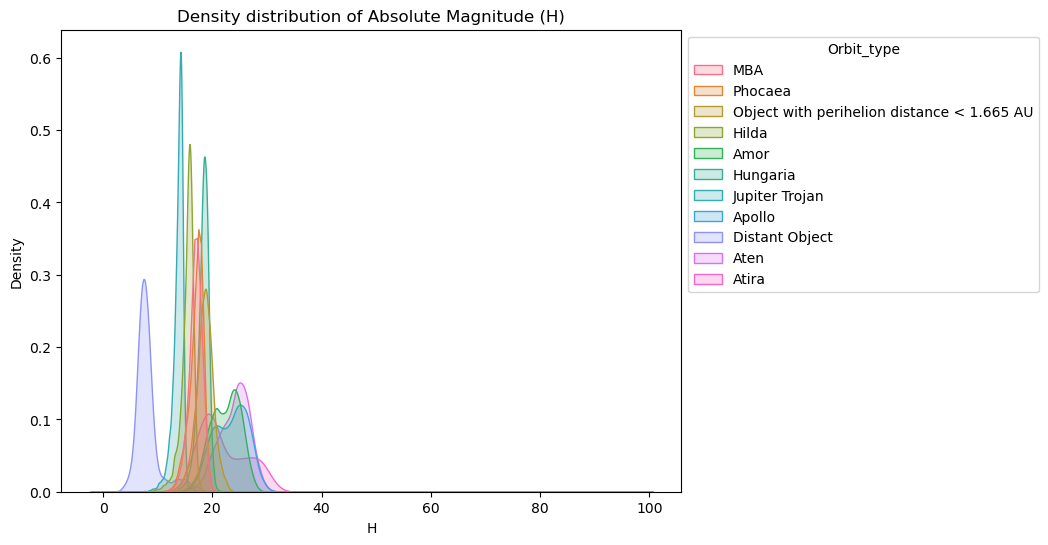

In [23]:
# Plot density of Absolute Magnitude, 'H'
plt.figure(figsize=(8,6))
dens_plot = sns.kdeplot(df, x = 'H', hue = 'Orbit_type', fill = True, common_norm = False)

plt.title("Density distribution of Absolute Magnitude (H)")

sns.move_legend(dens_plot, "upper left", bbox_to_anchor=(1, 1))

plt.show()

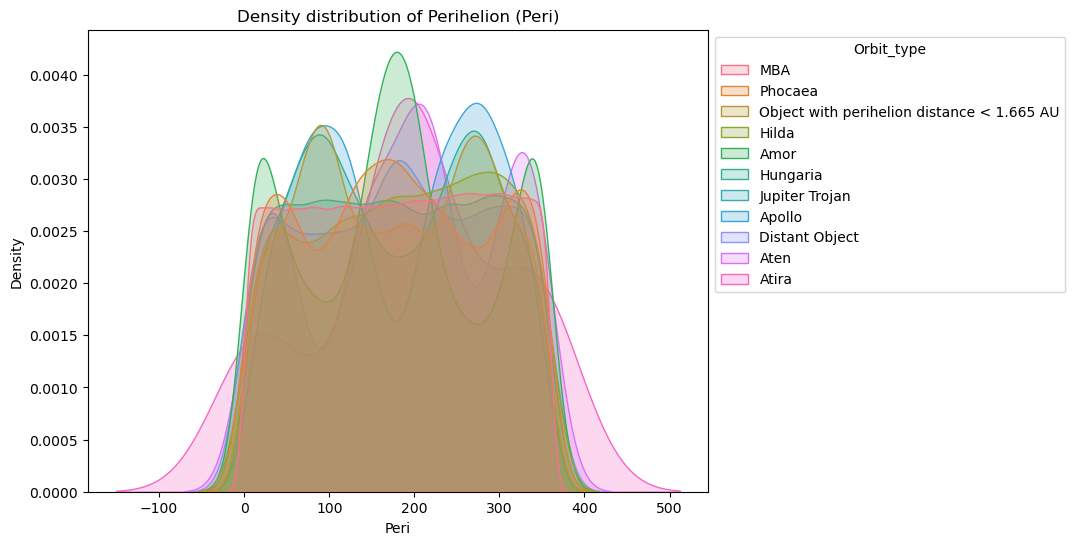

In [24]:
# Plot density of Perihelion, 'Peri'
plt.figure(figsize=(8,6))
dens_plot = sns.kdeplot(df, x = 'Peri', hue = 'Orbit_type', fill = True, common_norm = False)

plt.title("Density distribution of Perihelion (Peri)")

sns.move_legend(dens_plot, "upper left", bbox_to_anchor=(1, 1))

plt.show()

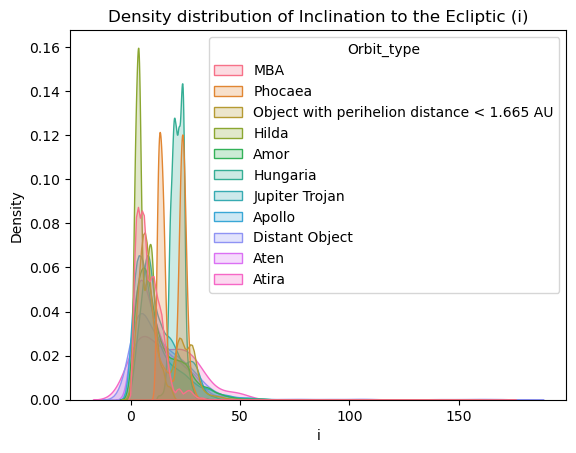

In [25]:
# Plot density of Inclination to the ecliptic, 'i'
dens_plot = sns.kdeplot(df, x = 'i', hue = 'Orbit_type', fill = True, common_norm = False)

plt.title("Density distribution of Inclination to the Ecliptic (i)")

plt.show()

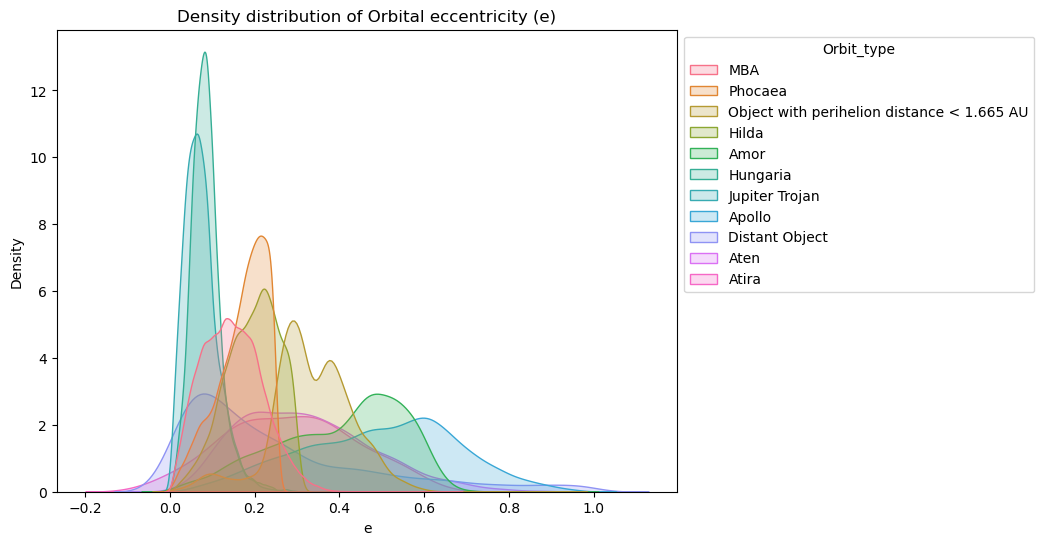

In [26]:
# Plot density of Orbital Eccentricity, 'e'
plt.figure(figsize=(8,6))
dens_plot = sns.kdeplot(df, x = 'e', hue = 'Orbit_type', fill = True, common_norm = False)

plt.title("Density distribution of Orbital eccentricity (e)")

# Move the legend within the graph area
sns.move_legend(dens_plot, "upper left", bbox_to_anchor=(1, 1))

plt.show()

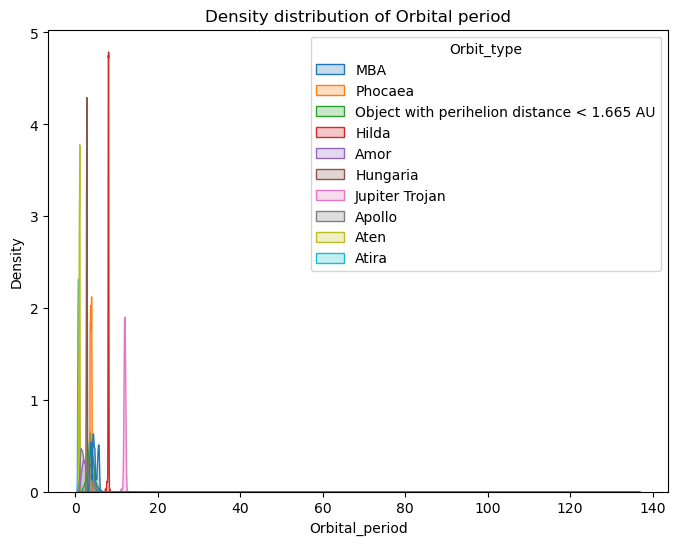

In [27]:
# Create density distribution of orbital type
plt.figure(figsize=(8,6))
dens_plot = sns.kdeplot(df.loc[df['Orbit_type'] != 'Distant Object'], x = 'Orbital_period', hue = 'Orbit_type', fill = True, common_norm = False)

plt.title('Density distribution of Orbital period')

plt.show()

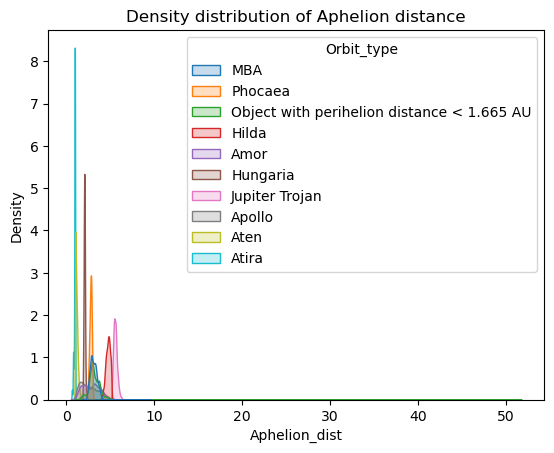

In [28]:
# Create boxplot of Aphelion distance. Density plots dont show much since distribution is heavily right skewed
dens_plot = sns.kdeplot(df.loc[df['Orbit_type'] != 'Distant Object'], x = 'Aphelion_dist', hue = 'Orbit_type', fill = True, common_norm = False)

plt.title("Density distribution of Aphelion distance")

plt.show()

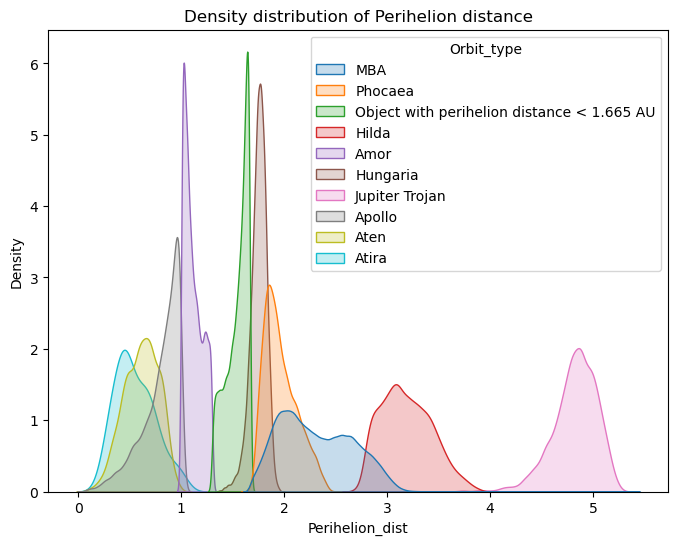

In [29]:
# Create density plot of Perihelion distance
plt.figure(figsize=(8,6))
dens_plot = sns.kdeplot(df.loc[df['Orbit_type'] != 'Distant Object'], x = 'Perihelion_dist', hue = 'Orbit_type', fill = True, common_norm = False)

plt.title("Density distribution of Perihelion distance")

plt.show()

In [30]:
# Extracting categorical column names
categorical_columns = df.drop('Orbit_type', axis = 1).select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['U', 'Perturbers', 'Perturbers_2', 'Computer'], dtype='object')

In [31]:
# Impute missing values in categorical columns with the mode
# Many categories are imbalanced so test set leakage won't occur when imputing before splitting
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

In [32]:
# One hot encode the features 'Perturbers' and 'Perturbers_2' as they have small number of unique classes
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

df_clean = one_hot.fit_transform(df[['Perturbers', 'Perturbers_2']])

df_clean = pd.DataFrame(df_clean, columns = one_hot.get_feature_names_out(['Perturbers', 'Perturbers_2']))

df_clean = pd.concat([df_clean, df.drop(columns = ['Perturbers', 'Perturbers_2'])], axis = 1)

In [33]:
# Checking the dataframe
df_clean

,Perturbers_M-h,Perturbers_M-v,Perturbers_Other,Perturbers_2_38h,Perturbers_2_3Eh,Perturbers_2_3Ek,Perturbers_2_Other,NEO_flag,One_km_NEO_flag,PHA_flag,...,a,Num_opps,Computer,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.766089,118,Pan,2.459921e+06,4.600439,2.549868,2.982310,1.374594,1.277744,MBA
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.774382,115,Pan,2.460009e+06,4.621142,2.136967,3.411796,1.313968,1.276156,MBA
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.668020,114,Pan,2.458446e+06,4.357963,1.982371,3.353669,1.245908,1.297800,MBA
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.362030,107,Pan,2.459574e+06,3.630180,2.153168,2.570893,1.171781,1.380202,MBA
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.573621,81,Pan,2.458926e+06,4.128733,2.082605,3.064637,1.239971,1.319618,MBA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048114,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.315735,1,Bell,2.458885e+06,3.523979,1.535778,3.095691,1.026520,1.396200,Object with perihelion distance < 1.665 AU
1048115,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.824870,1,Bell,2.458963e+06,2.465176,1.614955,2.034785,0.900362,1.682512,Hungaria
1048116,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.824509,1,Bell,2.458928e+06,2.464443,1.645878,2.003139,0.903510,1.682853,Hungaria
1048117,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.806399,1,Bell,2.459157e+06,4.701366,1.632723,3.980075,1.157775,1.270171,Object with perihelion distance < 1.665 AU


In [34]:
# Split the data into training, validation and testing sets
df_features = df_clean.drop('Orbit_type', axis = 1)
df_target = df_clean['Orbit_type']

X_trainval, X_test, y_trainval, y_test = train_test_split(df_features, df_target, test_size = 0.2, random_state = 2023)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, random_state = 2023)

In [35]:
# Benchmark model
benchmark_pred = ["MBA"] * len(y_test)

benchmark_accuracy = accuracy_score(y_test, benchmark_pred)
print("Accuracy of Benchmark Model:", benchmark_accuracy)

Accuracy of Benchmark Model: 0.9086364156775941


c:\Users\brand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\brand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\brand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



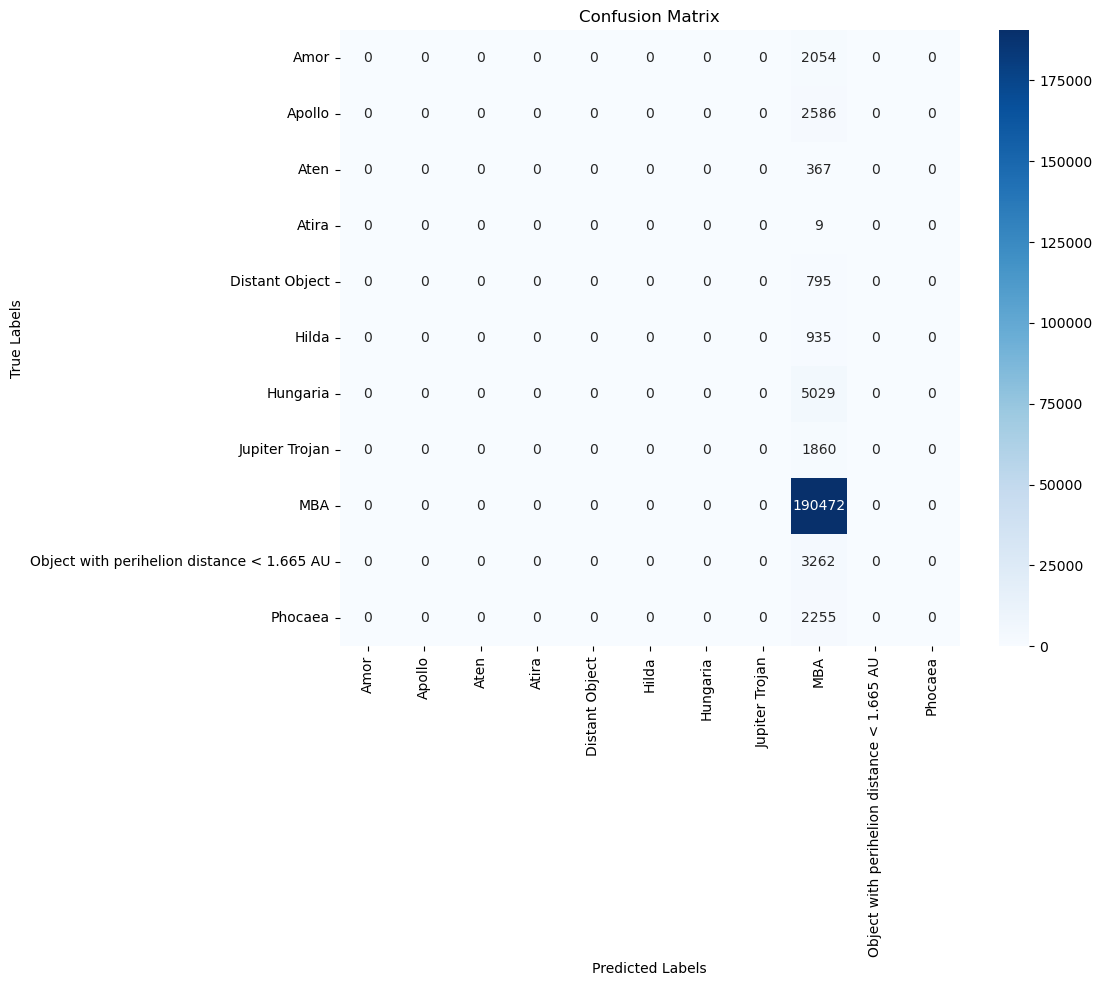

Classification Report:
                                            precision    recall  f1-score   support

                                      Amor     0.0000    0.0000    0.0000      2054
                                    Apollo     0.0000    0.0000    0.0000      2586
                                      Aten     0.0000    0.0000    0.0000       367
                                     Atira     0.0000    0.0000    0.0000         9
                            Distant Object     0.0000    0.0000    0.0000       795
                                     Hilda     0.0000    0.0000    0.0000       935
                                  Hungaria     0.0000    0.0000    0.0000      5029
                            Jupiter Trojan     0.0000    0.0000    0.0000      1860
                                       MBA     0.9086    1.0000    0.9521    190472
Object with perihelion distance < 1.665 AU     0.0000    0.0000    0.0000      3262
                                   Phocaea     0.000

In [36]:
# Create confusion matrix and classification report
cm = confusion_matrix(y_test, benchmark_pred)
report = classification_report(y_test, benchmark_pred, digits = 4)

class_labels = sorted(set(y_val))

# Plotting the confusion matrix
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap = 'Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(report)

In [37]:
# Test the performance of the benchmark model on the training set
benchmark_pred = ["MBA"] * len(y_train)
report = classification_report(y_train, benchmark_pred, digits = 4)
print(report)

c:\Users\brand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\brand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                                            precision    recall  f1-score   support

                                      Amor     0.0000    0.0000    0.0000      6216
                                    Apollo     0.0000    0.0000    0.0000      7489
                                      Aten     0.0000    0.0000    0.0000      1153
                                     Atira     0.0000    0.0000    0.0000        30
                            Distant Object     0.0000    0.0000    0.0000      2422
                                     Hilda     0.0000    0.0000    0.0000      2791
                                  Hungaria     0.0000    0.0000    0.0000     15227
                            Jupiter Trojan     0.0000    0.0000    0.0000      5649
                                       MBA     0.9078    1.0000    0.9517    570883
Object with perihelion distance < 1.665 AU     0.0000    0.0000    0.0000     10120
                                   Phocaea     0.0000    0.0000    0.0000  

c:\Users\brand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [38]:
# Before constructing neural network models, need to impute missing values
# Numerical data is imputed using median due to presence of right-skewed data
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_imputer = SimpleImputer(strategy = 'median')

X_train_impute = X_train
X_val_impute = X_val
X_test_impute = X_test

X_train_impute[numerical_columns] = numerical_imputer.fit_transform(X_train[numerical_columns])
X_val_impute[numerical_columns] = numerical_imputer.transform(X_val[numerical_columns])
X_test_impute[numerical_columns] = numerical_imputer.transform(X_test[numerical_columns])


In [39]:
# Checking for missing values
X_train_impute.isnull().sum()

Perturbers_M-h        0
Perturbers_M-v        0
Perturbers_Other      0
Perturbers_2_38h      0
Perturbers_2_3Eh      0
Perturbers_2_3Ek      0
Perturbers_2_Other    0
NEO_flag              0
One_km_NEO_flag       0
PHA_flag              0
H                     0
G                     0
Num_obs               0
rms                   0
U                     0
Arc_length            0
Epoch                 0
M                     0
Peri                  0
Node                  0
i                     0
e                     0
n                     0
a                     0
Num_opps              0
Computer              0
Tp                    0
Orbital_period        0
Perihelion_dist       0
Aphelion_dist         0
Semilatus_rectum      0
Synodic_period        0
dtype: int64

In [40]:
# Ordinal encode the categorical features
X_train_oe = X_train_impute
X_val_oe = X_val_impute
X_test_oe = X_test_impute

first_10_cols = X_train_impute.columns[:10].tolist()
encode_cols = first_10_cols + ['U', 'Computer']

oe = OrdinalEncoder()

X_train_oe[encode_cols] = oe.fit_transform(X_train_oe[encode_cols])
X_val_oe[encode_cols] = oe.transform(X_val_oe[encode_cols])
X_test_oe[encode_cols] = oe.transform(X_test_oe[encode_cols])


In [41]:
# List of all ordinal encoded features
for index in range(len(encode_cols)):
    print(encode_cols[index])
    for i, reg in enumerate(oe.categories_[index][:]):
        print(f"{reg} -> {i}")
    print()

Perturbers_M-h
0.0 -> 0
1.0 -> 1

Perturbers_M-v
0.0 -> 0
1.0 -> 1

Perturbers_Other
0.0 -> 0
1.0 -> 1

Perturbers_2_38h
0.0 -> 0
1.0 -> 1

Perturbers_2_3Eh
0.0 -> 0
1.0 -> 1

Perturbers_2_3Ek
0.0 -> 0
1.0 -> 1

Perturbers_2_Other
0.0 -> 0
1.0 -> 1

NEO_flag
0.0 -> 0
1.0 -> 1

One_km_NEO_flag
0.0 -> 0
1.0 -> 1

PHA_flag
0.0 -> 0
1.0 -> 1

U
0 -> 0
1 -> 1
2 -> 2
3 -> 3
4 -> 4
5 -> 5
6 -> 6
7 -> 7
8 -> 8
9 -> 9
D -> 10
E -> 11
Other -> 12

Computer
Alexanders -> 0
Bell -> 1
Doppler -> 2
Holman -> 3
MPCADO -> 4
MPCALB -> 5
MPCALI -> 6
MPCAPO -> 7
MPCD -> 8
MPCH -> 9
MPCK -> 10
MPCLINUX -> 11
MPCM -> 12
MPCMEL -> 13
MPCR -> 14
MPCS -> 15
MPCW -> 16
Marsden -> 17
Other -> 18
Pan -> 19
Payne -> 20
Pike -> 21
Rudenko -> 22
Spahr -> 23
Veres -> 24
Williams -> 25



In [42]:
# Performing ordinal encoding on the response data
oe = OrdinalEncoder()
# Reshape the y_train array
y_train_reshaped = y_train.values.reshape(-1, 1)

# Fit and transform y_train
y_train_oe = oe.fit_transform(y_train_reshaped)

# Transform y_val and y_test
y_val_oe = oe.transform(y_val.values.reshape(-1, 1))
y_test_oe = oe.transform(y_test.values.reshape(-1, 1))

In [43]:
# Listing the ordinal encoded response feature
for i, category in enumerate(oe.categories_[0]):
    print(f"{category} -> {i}")

Amor -> 0
Apollo -> 1
Aten -> 2
Atira -> 3
Distant Object -> 4
Hilda -> 5
Hungaria -> 6
Jupiter Trojan -> 7
MBA -> 8
Object with perihelion distance < 1.665 AU -> 9
Phocaea -> 10


In [44]:
# Standardising the data
X_train_sc = X_train_oe
X_val_sc = X_val_oe
X_test_sc = X_test_oe

sc = StandardScaler()

numerical_cols = [col for col in X_train_oe.columns if col not in encode_cols]

X_train_sc[numerical_cols] = sc.fit_transform(X_train_oe[numerical_cols])
X_val_sc[numerical_cols] = sc.transform(X_val_oe[numerical_cols])
X_test_sc[numerical_cols] = sc.transform(X_test_oe[numerical_cols])

In [45]:
# Checking the data before modelling
X_train_sc

,Perturbers_M-h,Perturbers_M-v,Perturbers_Other,Perturbers_2_38h,Perturbers_2_3Eh,Perturbers_2_3Ek,Perturbers_2_Other,NEO_flag,One_km_NEO_flag,PHA_flag,...,n,a,Num_opps,Computer,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period
105998,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.705650,0.035426,1.556458,19.0,-0.201656,-0.003694,0.179578,0.007288,0.132525,-0.045327
705877,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026697,-0.040791,-1.182564,24.0,-0.138789,-0.008052,-0.289315,0.005561,-0.158225,-0.020436
351181,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.186042,-0.025706,-0.086955,11.0,0.154074,-0.007220,0.095474,-0.043457,-0.016364,-0.026593
525343,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.154424,-0.028812,0.460849,19.0,-0.292554,-0.007393,0.088166,-0.045523,-0.024437,-0.025388
847120,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.652088,0.028080,-0.634760,24.0,0.252023,-0.004130,0.215637,-0.006614,0.121925,-0.043485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240547,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.022310,-0.045161,1.008654,19.0,0.379271,-0.008290,-0.143030,-0.023812,-0.102868,-0.018500
125623,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.682265,-0.094280,1.008654,19.0,-0.140749,-0.010875,-0.225000,-0.062152,-0.216172,0.009676
525876,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.076836,-0.036194,-0.452158,19.0,-0.240699,-0.007800,0.067768,-0.049919,-0.043843,-0.022396
150735,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.347442,-0.071394,1.008654,16.0,-0.084190,-0.009692,-0.203545,-0.041459,-0.167934,-0.005131


In [46]:
# Create simple dense sequential model
# Find number of unique classes in response variable
num_classes = len(np.unique(y_train_oe))

def hyper_sequential_model(hp):
    # Setting a seed to ensure consistent results
    random.seed(2023)
    
    model = Sequential()
    
    # Hyperparameter for number of hidden layers
    num_hidden_layers = hp.Int("num_hidden_layers", 1, 3)
    
    for i in range(num_hidden_layers):
        model.add(
            # Hyperparameter for number of neurons in each dense layer
            Dense(hp.Int(f"neurons_{i}", min_value = 16, max_value = 128, step = 16), \
                
                # Hyperparameter for activation function
                activation = hp.Choice(f"activation_{i}", values = ['relu', 'sigmoid', 'tanh']))
        )
        # Set a seed before dropout layer to ensure consistent results
        random.seed(2023)
        # Hyperparameter for the dropout rate
        model.add(
            Dropout(hp.Float(f"dropout_rate_{i}", min_value = 0.0, max_value = 0.5, step = 0.1))
        )

    # Softmax activation function
    model.add(Dense(
        num_classes,
        activation = 'softmax'
    ))

    # Adam optimiser and SparseCategoricalCrossentropy loss function
    model.compile(
        'adam',
        loss = 'SparseCategoricalCrossentropy',
        metrics = ['accuracy']
    )

    return model



In [47]:
# Setting class weights to deal with class imbalance. This was done using an inverse class frequency weighting scheme
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train_oe.flatten()), y = y_train_oe.flatten())

# Set early stopping
es = EarlyStopping(restore_best_weights = True, patience = 10, monitor = 'val_loss')

# Bayesian Optimisation using maximum 10 trials
sequential_tuner = kt.BayesianOptimization(hyper_sequential_model, objective = 'val_loss', directory = 'bayesian-search', max_trials = 10, seed = 2023, overwrite = True)

# Performing the search with max epoch 100, and batch size 128
sequential_tuner.search(X_train_sc, y_train_oe, epochs = 100, verbose = 2, callbacks = [es], validation_data = (X_val_sc, y_val_oe), batch_size = 128, class_weight = dict(enumerate(class_weights)))


Trial 10 Complete [00h 02m 48s]
val_loss: 0.12465975433588028

Best val_loss So Far: 0.01720409281551838
Total elapsed time: 01h 08m 29s
INFO:tensorflow:Oracle triggered exit


In [48]:
# Getting best hyperparameters
sequential_hp = sequential_tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters")
sequential_hp.values

Best Hyperparameters


{'num_hidden_layers': 1,
 'neurons_0': 128,
 'activation_0': 'tanh',
 'dropout_rate_0': 0.0,
 'neurons_1': 64,
 'activation_1': 'sigmoid',
 'dropout_rate_1': 0.1}

In [49]:
# Retrain the model with best hyperparameters
random.seed(2023)

best_sequential_model = Sequential()

# Hidden layer
for i in range(sequential_hp['num_hidden_layers']):
    best_sequential_model.add(Dense(
        sequential_hp[f'neurons_{i}'],
        activation = sequential_hp[f'activation_{i}'],
        name = f'hidden_{i}'
    ))
    # Set seed for dropout layer
    random.seed(2023)
    # Dropout layer
    best_sequential_model.add(Dropout(
        sequential_hp[f'dropout_rate_{i}'],
        name = f'dropout_{i}'
    ))

best_sequential_model.add(Dense(num_classes, activation = 'softmax', name = 'Output'))

best_sequential_model.compile(
    'adam',
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['accuracy']
    )
# Performing the training
history_sequential = best_sequential_model.fit(X_train_sc, y_train_oe, epochs = 100, batch_size = 128, validation_data = (X_val_sc, y_val_oe), \
    callbacks = [es], class_weight = dict(enumerate(class_weights)), verbose = 2)

Epoch 1/100
4914/4914 - 8s - loss: 0.4894 - accuracy: 0.8314 - val_loss: 0.1656 - val_accuracy: 0.9528 - 8s/epoch - 2ms/step
Epoch 2/100
4914/4914 - 7s - loss: 0.1959 - accuracy: 0.9517 - val_loss: 0.0855 - val_accuracy: 0.9714 - 7s/epoch - 1ms/step
Epoch 3/100
4914/4914 - 7s - loss: 0.1588 - accuracy: 0.9711 - val_loss: 0.0648 - val_accuracy: 0.9779 - 7s/epoch - 1ms/step
Epoch 4/100
4914/4914 - 7s - loss: 0.1207 - accuracy: 0.9771 - val_loss: 0.0629 - val_accuracy: 0.9786 - 7s/epoch - 1ms/step
Epoch 5/100
4914/4914 - 7s - loss: 0.1141 - accuracy: 0.9798 - val_loss: 0.0844 - val_accuracy: 0.9738 - 7s/epoch - 1ms/step
Epoch 6/100
4914/4914 - 7s - loss: 0.1058 - accuracy: 0.9818 - val_loss: 0.0569 - val_accuracy: 0.9812 - 7s/epoch - 1ms/step
Epoch 7/100
4914/4914 - 8s - loss: 0.1117 - accuracy: 0.9832 - val_loss: 0.0439 - val_accuracy: 0.9848 - 8s/epoch - 2ms/step
Epoch 8/100
4914/4914 - 7s - loss: 0.0947 - accuracy: 0.9841 - val_loss: 0.0448 - val_accuracy: 0.9846 - 7s/epoch - 1ms/step


In [50]:
# Summary of the best model 1
best_sequential_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 128)               4224      
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 Output (Dense)              (None, 11)                1419      
                                                                 
Total params: 5,643
Trainable params: 5,643
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Evaluate model 1 on test set
best_sequential_model.evaluate(X_test_sc, y_test_oe)

6551/6551 [==============================] - 7s 1ms/step - loss: 0.0168 - accuracy: 0.9943


[0.01679333858191967, 0.9943088293075562]

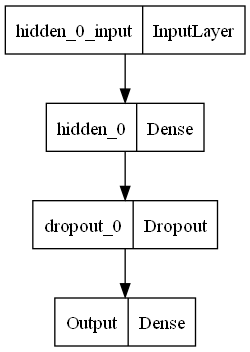

In [52]:

plot_model(best_sequential_model)

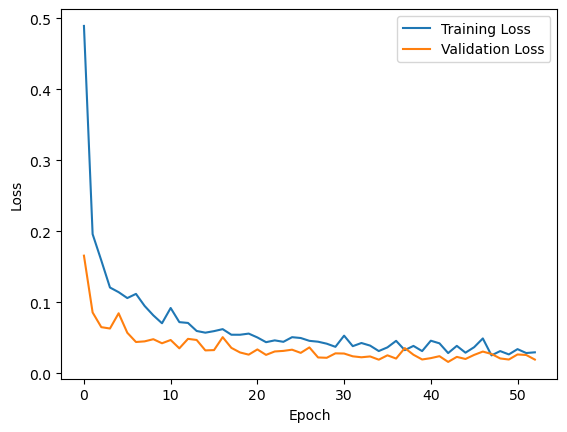

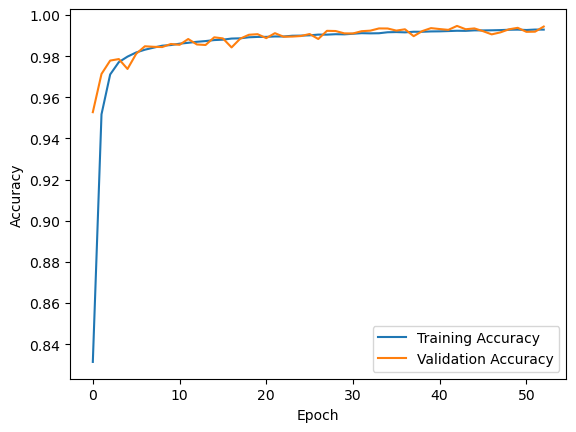

In [53]:
# Plot training and validation loss
plt.plot(history_sequential.history['loss'], label='Training Loss')
plt.plot(history_sequential.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_sequential.history['accuracy'], label='Training Accuracy')
plt.plot(history_sequential.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [54]:
# Make predictions on the test set
y_prob = best_sequential_model.predict(X_test_sc)

# Convert predictions to class labels
pred_sequential = np.argmax(y_prob, axis=1)

6551/6551 [==============================] - 6s 862us/step


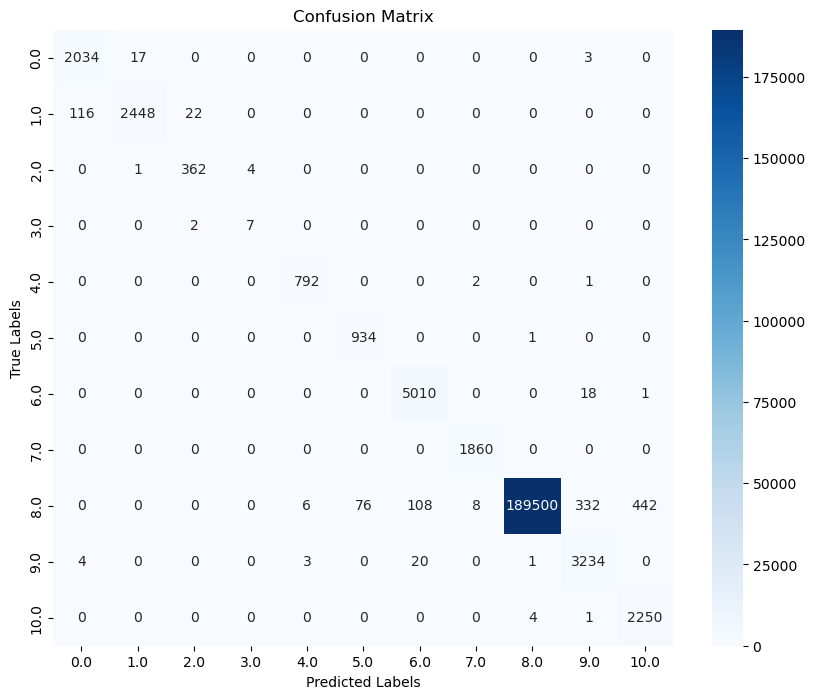

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9443    0.9903    0.9667      2054
         1.0     0.9927    0.9466    0.9691      2586
         2.0     0.9378    0.9864    0.9615       367
         3.0     0.6364    0.7778    0.7000         9
         4.0     0.9888    0.9962    0.9925       795
         5.0     0.9248    0.9989    0.9604       935
         6.0     0.9751    0.9962    0.9855      5029
         7.0     0.9947    1.0000    0.9973      1860
         8.0     1.0000    0.9949    0.9974    190472
         9.0     0.9011    0.9914    0.9441      3262
        10.0     0.8355    0.9978    0.9095      2255

    accuracy                         0.9943    209624
   macro avg     0.9210    0.9706    0.9440    209624
weighted avg     0.9949    0.9943    0.9945    209624



In [55]:
# Create confusion matrix and classification report
cm = confusion_matrix(y_test_oe, pred_sequential)
report = classification_report(y_test_oe, pred_sequential, digits = 4)

class_labels = sorted(np.unique(y_test_oe))

# Plotting the confusion matrix
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap = 'Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(report)

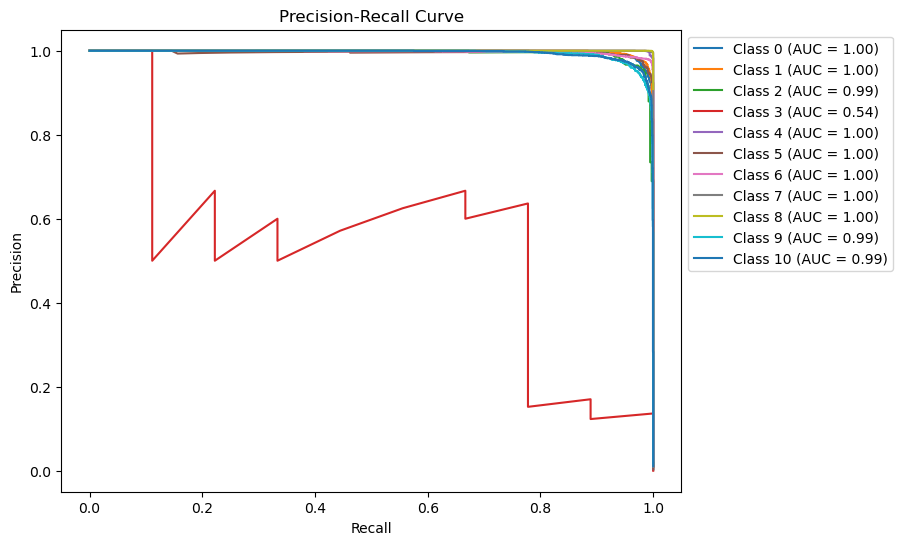

In [56]:
# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_pred_prob, n_classes):
    # Binarise true values
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    
    precision = dict()
    recall = dict()
    thresholds = dict()
    precision_recall_auc = dict()

    # Perform one vs rest precision recall curve and store the results
    for i in range(n_classes):
        precision[i], recall[i], thresholds[i] = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
        precision_recall_auc[i] = auc(recall[i], precision[i])

    # Plot each graph
    plt.figure(figsize = (8,6))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label = 'Class {0} (AUC = {1:.2f})'.format(i, precision_recall_auc[i]))

    # X and Y labels, title
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
    plt.show()

# Plot the precision-recall curve for Model 1 on the test set
plot_precision_recall_curve(y_test_oe, y_prob, 11)

In [57]:
# Make predictions on the train set
y_prob = best_sequential_model.predict(X_train_sc)

# Convert predictions to class labels
pred_sequential = np.argmax(y_prob, axis=1)
report = classification_report(y_train_oe, pred_sequential, digits = 4)
print(report)

19653/19653 [==============================] - 17s 862us/step
              precision    recall  f1-score   support

         0.0     0.9597    0.9969    0.9780      6216
         1.0     0.9972    0.9599    0.9782      7489
         2.0     0.9582    0.9931    0.9753      1153
         3.0     0.8333    1.0000    0.9091        30
         4.0     0.9922    1.0000    0.9961      2422
         5.0     0.9115    1.0000    0.9537      2791
         6.0     0.9735    0.9971    0.9851     15227
         7.0     0.9965    1.0000    0.9982      5649
         8.0     1.0000    0.9950    0.9975    570883
         9.0     0.9146    0.9943    0.9528     10120
        10.0     0.8412    0.9994    0.9135      6891

    accuracy                         0.9947    628871
   macro avg     0.9434    0.9942    0.9670    628871
weighted avg     0.9953    0.9947    0.9949    628871



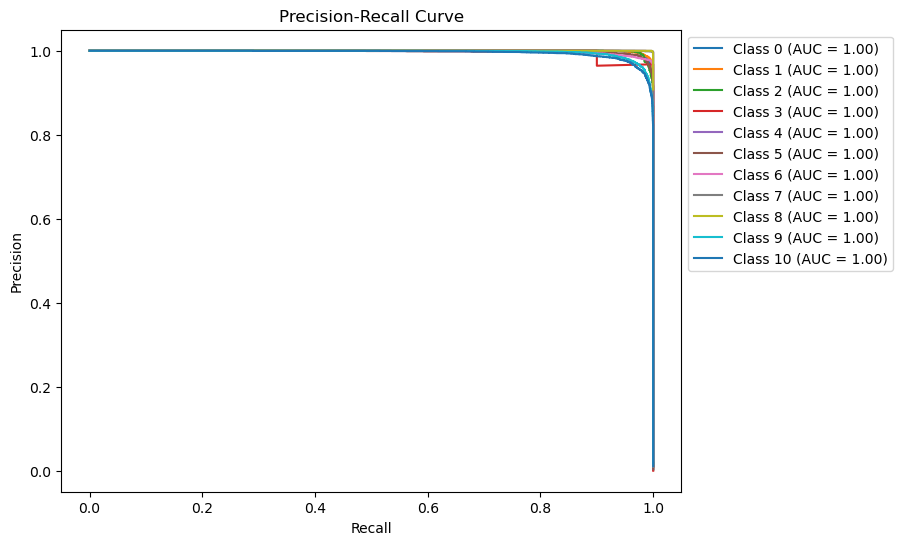

In [58]:
# Precision-recall curve for Model 1 on the training set 
plot_precision_recall_curve(y_train_oe, y_prob, 11)

In [59]:
# Permutation test function
def permutation_test(model, X, y, num_reps = 1, seed = 2023):

    # Create temporary array
    temp = X.values
    random.seed(seed)
    scores = []

    # Permutation algorithm
    for j in range(X.shape[1]):
        original_column = np.copy(temp[:, j])
        col_scores = []

        for r in range(num_reps):
            # Random Shuffling
            random.shuffle(temp[:,j])
            y_prob = model.predict(temp, verbose = 0)
            y_pred = np.argmax(y_prob, axis=1)
            
            # Use macro-average f1-score as the metric instead of accuracy
            class_report = classification_report(y, y_pred, output_dict=True)
            macro_avg = class_report['macro avg']['f1-score']
            col_scores.append(macro_avg)

        scores.append(np.mean(col_scores, axis = 0))
        temp[:,j] = original_column

    return np.array(scores)

Text(0, 0.5, 'Accuracy when shuffled')

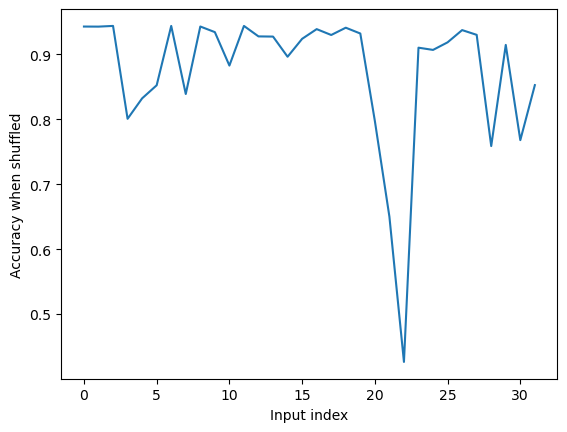

In [60]:
# Performing permutation test for variable importance
perm_scores = permutation_test(best_sequential_model, X_test_sc, y_test_oe)
plt.plot(perm_scores)
plt.xlabel("Input index"); plt.ylabel("Accuracy when shuffled")

In [61]:
# Most important features
cols = X_test_sc.columns.tolist()
best_input_inds = np.argsort(perm_scores)
best_inputs = [cols[idx] for idx in best_input_inds]
best_inputs

['n',
 'e',
 'Perihelion_dist',
 'Semilatus_rectum',
 'i',
 'Perturbers_2_38h',
 'Perturbers_2_3Eh',
 'NEO_flag',
 'Perturbers_2_3Ek',
 'Synodic_period',
 'H',
 'U',
 'Num_opps',
 'a',
 'Aphelion_dist',
 'Computer',
 'Arc_length',
 'rms',
 'Num_obs',
 'M',
 'Orbital_period',
 'Node',
 'PHA_flag',
 'Tp',
 'Epoch',
 'Peri',
 'Perturbers_M-v',
 'Perturbers_M-h',
 'One_km_NEO_flag',
 'G',
 'Perturbers_2_Other',
 'Perturbers_Other']

In [62]:
# Splitting the data into categorical, boolean and numerical features for Model 2
X_train_U = X_train_sc['U']; X_val_U = X_val_sc['U']; X_test_U = X_test_sc['U']
X_train_Comp = X_train_sc['Computer']; X_val_Comp = X_val_sc['Computer']; X_test_Comp = X_test_sc['Computer']

X_train_bool = X_train_sc.iloc[:, 0:10]; X_val_bool = X_val_sc.iloc[:, 0:10]; X_test_bool = X_test_sc.iloc[:, 0:10]

drop_cols = list(X_train_bool.columns) + ['U', 'Computer']

X_train_rest = X_train_sc.drop(drop_cols, axis = 1); X_val_rest = X_val_sc.drop(drop_cols, axis = 1); X_test_rest = X_test_sc.drop(drop_cols, axis = 1)

In [63]:
# Model 2 uses a wide neural network architecture
def hyper_wide_model(hp):
    random.seed(2023)
    
    # Setting inputs
    U_input = Input(shape = (1,), name = 'U_input')
    Comp_input = Input(shape = (1,), name = 'Computer_input')
    bool_input = Input(shape = (X_train_bool.shape[1],), name = 'Boolean_inputs')
    rest_input = Input(shape = (X_train_rest.shape[1],), name = "Other_variables")

    # Unique classes for categorical features
    num_U = X_train_sc['U'].nunique()
    num_Comp = X_train_sc['Computer'].nunique()

    # Embedding layer using categorical features
    U_embed = Embedding(input_dim = num_U, output_dim = 5, name = "U_Embedding")(U_input)
    U_embed = Reshape(target_shape = (5,), name = "U_Reshape")(U_embed)
    Comp_embed = Embedding(input_dim = num_Comp, output_dim = 6, name = "Computer_Embedding")(Comp_input)
    Comp_embed = Reshape(target_shape = (6,), name = 'Computer_Reshape')(Comp_embed)

    # Concatenate embedding layer with boolean features
    cat_conc = Concatenate(name = 'combine_categorical')([U_embed, Comp_embed, bool_input])
    cat_dense = Dense(
        hp.Int('neurons_categorical', min_value = 16, max_value = 128, step = 16), \
            activation = hp.Choice('activation_categorical', values = ['relu', 'sigmoid', 'tanh']), \
                name = 'dense_categorical')(cat_conc)
    
    # Set seed before dropout layer            
    random.seed(2023)
    cat_dropout = Dropout(
        hp.Float('dropout_categorical', min_value = 0.0, max_value = 0.5, step = 0.1), \
                 name = 'dropout_categorical')(cat_dense)

    # Dense/Dropout layer using numerical features only
    rest_dense = Dense(
        hp.Int('neurons_numerical', min_value = 16, max_value = 128, step = 16), \
            activation = hp.Choice('activation_numerical', values = ['relu', 'sigmoid', 'tanh']), \
                name = 'dense_numerical')(rest_input)
    
    # Set seed before dropout layer
    random.seed(2023)
    rest_dropout = Dropout(
        hp.Float('dropout_numerical', min_value = 0.0, max_value = 0.5, step = 0.1), \
            name = 'dropout_numerical')(rest_dense)

    # Concatenate all layers together
    all_inputs = Concatenate(name = 'Combine_all')([cat_dropout, rest_dropout])
    all_dense = Dense(
        hp.Int('neurons_all', min_value = 16, max_value = 128, step = 16), \
            activation = hp.Choice('activation_all', values = ['relu', 'sigmoid', 'tanh']), \
                name = 'dense_all')(all_inputs)
    
    # Set seed before dropout layer
    random.seed(2023)
    all_dropout = Dropout(
        hp.Float('dropout_all', min_value = 0.0, max_value = 0.5, step = 0.1), \
            name = 'dropout_all')(all_dense)

    # Softmax activation function
    out = Dense(num_classes, activation = 'softmax', name = 'Output')(all_dropout)

    model = Model([U_input, Comp_input, bool_input, rest_input], outputs = out)

    # Adam optimiser and SparseCategoricalCrossentropy loss function
    model.compile('adam', loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])
    
    return model

In [64]:
# Same parameters as Model 1 with class weights, early stopping, bayesian optimisation, epoch and batch size
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train_oe.flatten()), y = y_train_oe.flatten())

es = EarlyStopping(restore_best_weights = True, patience = 10, monitor = 'val_loss')

wide_tuner = kt.BayesianOptimization(hyper_wide_model, objective = 'val_loss', directory = 'bayesian-search-wide', max_trials = 10, seed = 2023, overwrite = True)

wide_tuner.search((X_train_U, X_train_Comp, X_train_bool, X_train_rest), y_train_oe, \
                        epochs = 100, verbose = 2, callbacks = [es], \
                            validation_data = ((X_val_U, X_val_Comp, X_val_bool, X_val_rest), y_val_oe), batch_size = 128, class_weight = dict(enumerate(class_weights)))

Trial 10 Complete [00h 05m 43s]
val_loss: 0.03772210702300072

Best val_loss So Far: 0.02054930292069912
Total elapsed time: 01h 04m 37s
INFO:tensorflow:Oracle triggered exit


In [65]:
# Best hyperparameters for Model 2
wide_hp = wide_tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters")
wide_hp.values

Best Hyperparameters


{'neurons_categorical': 80,
 'activation_categorical': 'relu',
 'dropout_categorical': 0.4,
 'neurons_numerical': 48,
 'activation_numerical': 'relu',
 'dropout_numerical': 0.0,
 'neurons_all': 128,
 'activation_all': 'tanh',
 'dropout_all': 0.0}

In [66]:
# Retrain Model 2
random.seed(2023)

# Input layer
U_input = Input(shape = (1,), name = 'U_input')
Comp_input = Input(shape = (1,), name = 'Computer_input')
bool_input = Input(shape = (X_train_bool.shape[1],), name = 'Boolean_inputs')
rest_input = Input(shape = (X_train_rest.shape[1],), name = "Other_variables")

# Unique classes
num_U = X_train_sc['U'].nunique()
num_Comp = X_train_sc['Computer'].nunique()

# Embedding layer
U_embed = Embedding(input_dim = num_U, output_dim = 5, name = "U_Embedding")(U_input)
U_embed = Reshape(target_shape = (5,), name = "U_Reshape")(U_embed)
Comp_embed = Embedding(input_dim = num_Comp, output_dim = 6, name = "Computer_Embedding")(Comp_input)
Comp_embed = Reshape(target_shape = (6,), name = 'Computer_Reshape')(Comp_embed)

# Concatenate embeddings with boolean features
cat_conc = Concatenate(name = 'Combine_categorical')([U_embed, Comp_embed, bool_input])
cat_dense = Dense(wide_hp['neurons_categorical'], activation = wide_hp['activation_categorical'], name = 'dense_categorical')(cat_conc)
random.seed(2023)
cat_dropout = Dropout(wide_hp['dropout_categorical'], name = 'dropout_categorical')(cat_dense)

# Dense/Dropout layer for numerical features
rest_dense = Dense(wide_hp['neurons_numerical'], activation = wide_hp['activation_numerical'], name = 'dense_numerical')(rest_input)
random.seed(2023)
rest_dropout = Dropout(wide_hp['dropout_numerical'], name = 'dropout_numerical')(rest_dense)

# Concatenate all layers
all_inputs = Concatenate(name = 'combine_all')([cat_dropout, rest_dropout])
all_dense = Dense(wide_hp['neurons_all'], activation = wide_hp['activation_all'], name = 'dense_all')(all_inputs)
random.seed(2023)
all_dropout = Dropout(wide_hp['dropout_all'], name = 'dropout_all')(all_dense)

# Softmax activation function for output
out = Dense(num_classes, activation = 'softmax', name = 'Output')(all_dropout)

best_wide_model = Model([U_input, Comp_input, bool_input, rest_input], outputs = out)

best_wide_model.compile('adam', loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

# Training the model
history_wide = best_wide_model.fit((X_train_U, X_train_Comp, X_train_bool, X_train_rest), y_train_oe, epochs = 100, batch_size = 128, \
    validation_data = ((X_val_U, X_val_Comp, X_val_bool, X_val_rest), y_val_oe), \
        callbacks = [es], class_weight = dict(enumerate(class_weights)), verbose = 2)

Epoch 1/100
4914/4914 - 12s - loss: 0.3799 - accuracy: 0.9083 - val_loss: 0.1077 - val_accuracy: 0.9635 - 12s/epoch - 3ms/step
Epoch 2/100
4914/4914 - 11s - loss: 0.2002 - accuracy: 0.9691 - val_loss: 0.0670 - val_accuracy: 0.9770 - 11s/epoch - 2ms/step
Epoch 3/100
4914/4914 - 11s - loss: 0.1712 - accuracy: 0.9763 - val_loss: 0.0602 - val_accuracy: 0.9799 - 11s/epoch - 2ms/step
Epoch 4/100
4914/4914 - 11s - loss: 0.1787 - accuracy: 0.9803 - val_loss: 0.0482 - val_accuracy: 0.9836 - 11s/epoch - 2ms/step
Epoch 5/100
4914/4914 - 11s - loss: 0.1431 - accuracy: 0.9830 - val_loss: 0.0461 - val_accuracy: 0.9845 - 11s/epoch - 2ms/step
Epoch 6/100
4914/4914 - 11s - loss: 0.1605 - accuracy: 0.9837 - val_loss: 0.0495 - val_accuracy: 0.9844 - 11s/epoch - 2ms/step
Epoch 7/100
4914/4914 - 12s - loss: 0.1486 - accuracy: 0.9853 - val_loss: 0.0413 - val_accuracy: 0.9876 - 12s/epoch - 2ms/step
Epoch 8/100
4914/4914 - 12s - loss: 0.1401 - accuracy: 0.9866 - val_loss: 0.0413 - val_accuracy: 0.9866 - 12s/e

In [67]:
# Evalute model 2 performance on the test set 
best_wide_model.evaluate((X_test_U, X_test_Comp, X_test_bool, X_test_rest), y_test_oe)

6551/6551 [==============================] - 8s 1ms/step - loss: 0.0208 - accuracy: 0.9930


[0.020808923989534378, 0.9930399060249329]

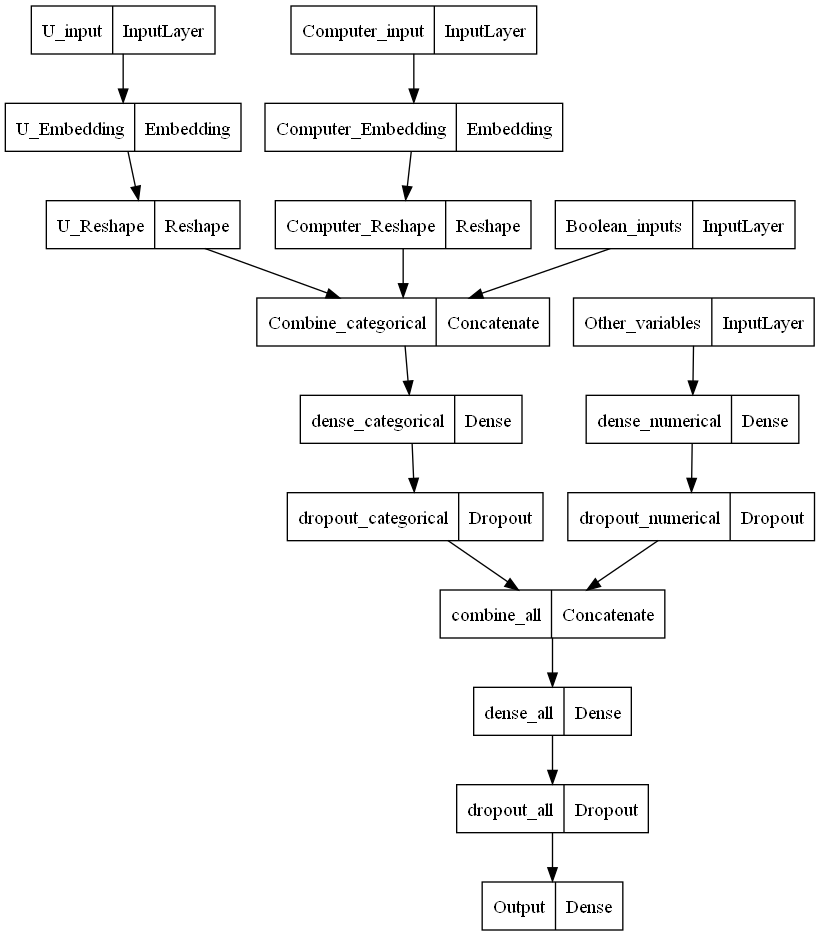

In [68]:
# Plot Model 2 architecture
plot_model(best_wide_model)

In [69]:
# Summary of Model 2
best_wide_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 U_input (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Computer_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 U_Embedding (Embedding)        (None, 1, 5)         65          ['U_input[0][0]']                
                                                                                                  
 Computer_Embedding (Embedding)  (None, 1, 6)        156         ['Computer_input[0][0]']         
                                                                                            

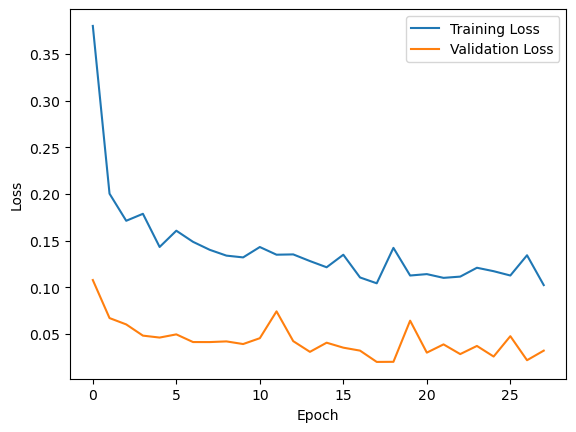

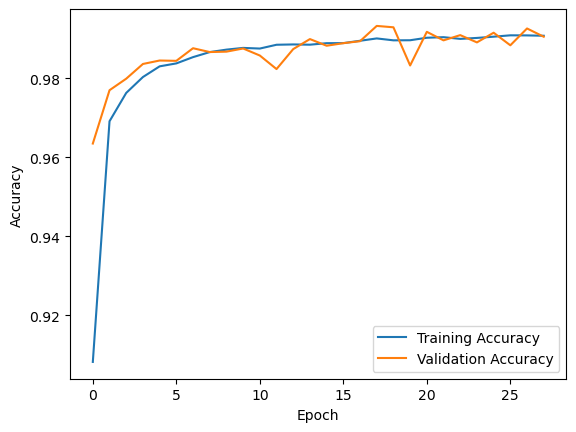

In [70]:
# Plot training and validation loss
plt.plot(history_wide.history['loss'], label='Training Loss')
plt.plot(history_wide.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_wide.history['accuracy'], label='Training Accuracy')
plt.plot(history_wide.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [71]:
# Make predictions on the test set
y_prob_wide = best_wide_model.predict((X_test_U, X_test_Comp, X_test_bool, X_test_rest))

# Convert predictions to class labels
pred_wide = np.argmax(y_prob_wide, axis=1)

6551/6551 [==============================] - 7s 1ms/step


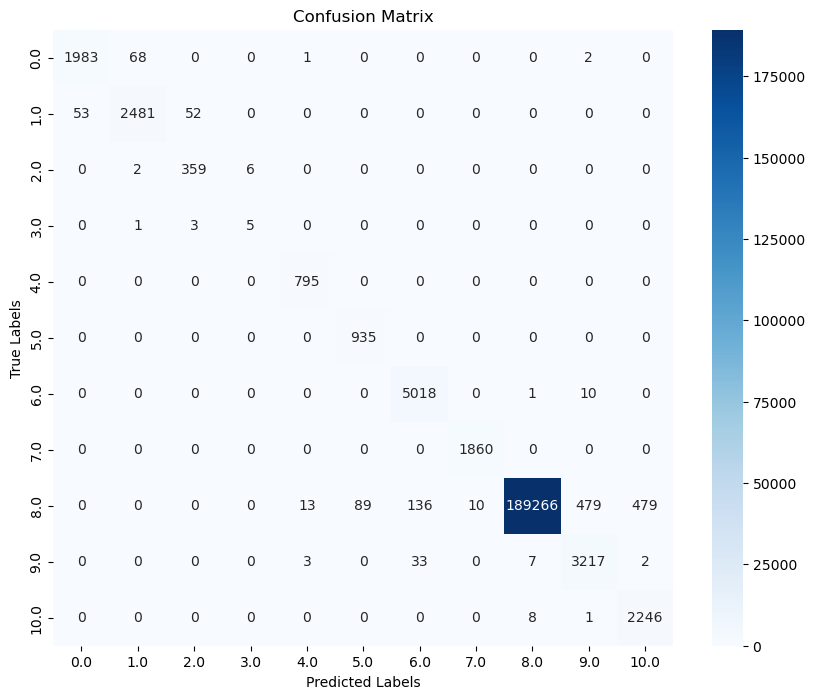

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9740    0.9654    0.9697      2054
         1.0     0.9722    0.9594    0.9657      2586
         2.0     0.8671    0.9782    0.9193       367
         3.0     0.4545    0.5556    0.5000         9
         4.0     0.9791    1.0000    0.9894       795
         5.0     0.9131    1.0000    0.9546       935
         6.0     0.9674    0.9978    0.9824      5029
         7.0     0.9947    1.0000    0.9973      1860
         8.0     0.9999    0.9937    0.9968    190472
         9.0     0.8673    0.9862    0.9230      3262
        10.0     0.8236    0.9960    0.9016      2255

    accuracy                         0.9930    209624
   macro avg     0.8921    0.9484    0.9182    209624
weighted avg     0.9938    0.9930    0.9932    209624



In [72]:
# Create confusion matrix and classification report
cm = confusion_matrix(y_test_oe, pred_wide)
report = classification_report(y_test_oe, pred_wide, digits = 4)

class_labels = sorted(np.unique(y_test_oe))

# Plotting the confusion matrix
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap = 'Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(report)

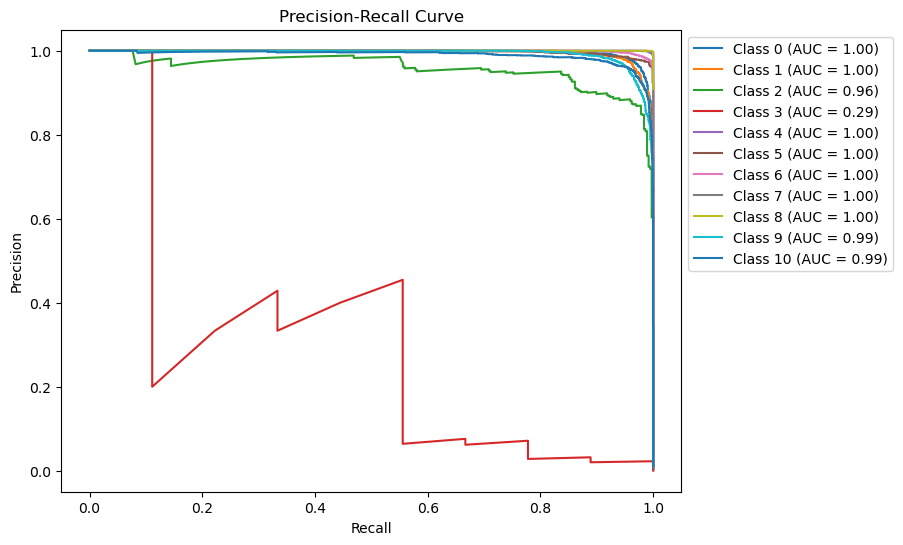

In [73]:
# Precision-recall curve of model 2 on the test set
plot_precision_recall_curve(y_test_oe, y_prob_wide, 11)

In [74]:
# Make predictions on the train set
y_prob_wide = best_wide_model.predict((X_train_U, X_train_Comp, X_train_bool, X_train_rest))

# Convert predictions to class labels
pred_wide = np.argmax(y_prob_wide, axis=1)

report = classification_report(y_train_oe, pred_wide, digits = 4)
print(report)

19653/19653 [==============================] - 22s 1ms/step
              precision    recall  f1-score   support

         0.0     0.9796    0.9751    0.9773      6216
         1.0     0.9776    0.9623    0.9699      7489
         2.0     0.8704    0.9844    0.9239      1153
         3.0     0.8182    0.6000    0.6923        30
         4.0     0.9810    1.0000    0.9904      2422
         5.0     0.9024    1.0000    0.9487      2791
         6.0     0.9671    0.9984    0.9825     15227
         7.0     0.9952    1.0000    0.9976      5649
         8.0     1.0000    0.9938    0.9969    570883
         9.0     0.8809    0.9881    0.9314     10120
        10.0     0.8284    0.9994    0.9059      6891

    accuracy                         0.9934    628871
   macro avg     0.9273    0.9547    0.9379    628871
weighted avg     0.9941    0.9934    0.9936    628871



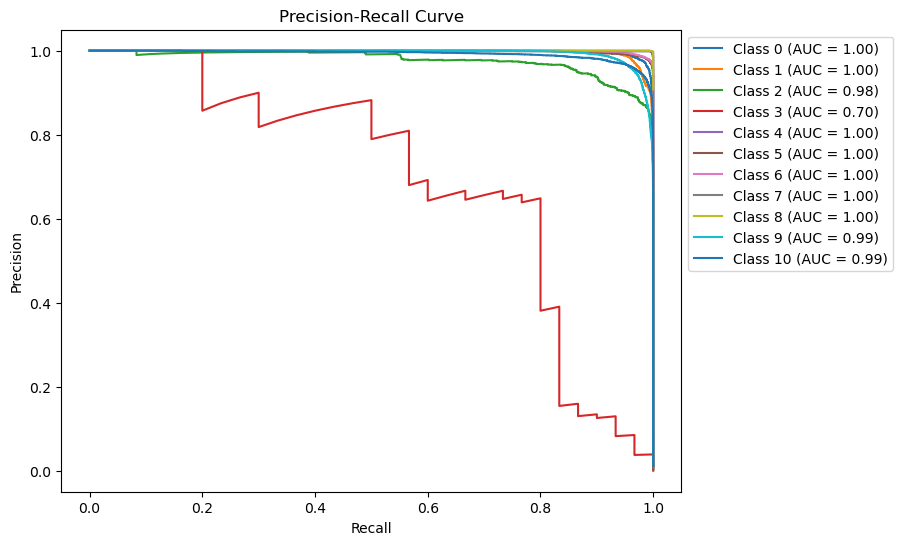

In [75]:
# Precision-recall curve of model 2 on the training set
plot_precision_recall_curve(y_train_oe, y_prob_wide, 11)

In [76]:
# Permutation test function for Model 2
def permutation_test_wide(model, X_u, X_comp, X_bool, X_rest, y, num_reps = 1, seed = 2023):

    random.seed(seed)
    scores = []
    # Performing permutation algorithm for 'U' input
    temp = X_u.values
    for j in range(1):
        original_column = temp
        col_scores = []

        for r in range(num_reps):
            # Random Shuffling
            random.shuffle(temp)
            y_prob = model.predict((temp, X_test_Comp, X_test_bool, X_test_rest), verbose = 0)
            y_pred = np.argmax(y_prob, axis=1)
            
            # Use macro average f1-score over accuracy for imbalanced classes
            class_report = classification_report(y, y_pred, output_dict=True)
            macro_avg = class_report['macro avg']['f1-score']
            col_scores.append(macro_avg)

        scores.append(np.mean(col_scores, axis = 0))
        temp = original_column

    # Performing permutation algorithm for 'Computer' input
    temp = X_comp.values
    for j in range(1):
        original_column = temp
        col_scores = []

        for r in range(num_reps):
            # Random Shuffling
            random.shuffle(temp)
            y_prob = model.predict((X_test_U, temp, X_test_bool, X_test_rest), verbose = 0)
            y_pred = np.argmax(y_prob, axis=1)

            # Use macro average f1-score over accuracy for imbalanced classes
            class_report = classification_report(y, y_pred, output_dict=True)
            macro_avg = class_report['macro avg']['f1-score']
            col_scores.append(macro_avg)

        scores.append(np.mean(col_scores, axis = 0))
        temp = original_column

    # Performing permuation algorithm for boolean inputs
    temp = X_bool.values
    for j in range(X_bool.shape[1]):
        original_column = np.copy(temp[:, j])
        col_scores = []

        for r in range(num_reps):
            # Random Shuffling
            random.shuffle(temp[:,j])
            y_prob = model.predict((X_test_U, X_test_Comp, temp, X_test_rest), verbose = 0)
            y_pred = np.argmax(y_prob, axis=1)

            # Use macro average f1-score over accuracy for imbalanced classes
            class_report = classification_report(y, y_pred, output_dict=True)
            macro_avg = class_report['macro avg']['f1-score']
            col_scores.append(macro_avg)

        scores.append(np.mean(col_scores, axis = 0))
        temp[:,j] = original_column

    # Performing permuation algorithm for numerical inputs
    temp = X_rest.values
    for j in range(X_rest.shape[1]):
        original_column = np.copy(temp[:, j])
        col_scores = []

        for r in range(num_reps):
            # Random Shuffling
            random.shuffle(temp[:,j])
            y_prob = model.predict((X_test_U, X_test_Comp, X_test_bool, temp), verbose = 0)
            y_pred = np.argmax(y_prob, axis=1)

            # Use macro average f1-score over accuracy for imbalanced classes
            class_report = classification_report(y, y_pred, output_dict=True)
            macro_avg = class_report['macro avg']['f1-score']
            col_scores.append(macro_avg)

        scores.append(np.mean(col_scores, axis = 0))
        temp[:,j] = original_column
        
    return np.array(scores)

Text(0, 0.5, 'Macro average f-1 score when shuffled')

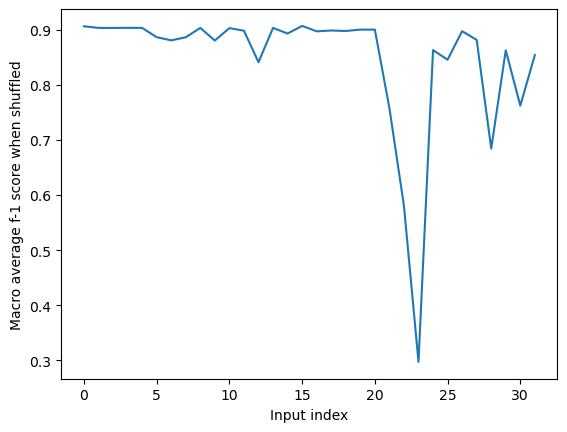

In [77]:
# Permutation test on Model 2
perm_scores_wide = permutation_test_wide(best_wide_model, X_test_U, X_test_Comp, X_test_bool, X_test_rest, y_test_oe)
plt.plot(perm_scores_wide)
plt.xlabel("Input index"); plt.ylabel("Macro average f-1 score when shuffled")

In [78]:
# Best features for Model 2
cols = ['U'] + ['Computer'] + X_test_bool.columns.tolist() + X_test_rest.columns.tolist()
best_input_inds = np.argsort(perm_scores_wide)
best_inputs_wide = [cols[idx] for idx in best_input_inds]
best_inputs_wide

['n',
 'e',
 'Perihelion_dist',
 'i',
 'Semilatus_rectum',
 'H',
 'Num_opps',
 'Synodic_period',
 'Aphelion_dist',
 'a',
 'NEO_flag',
 'Perturbers_2_3Eh',
 'Orbital_period',
 'Perturbers_2_3Ek',
 'Perturbers_2_38h',
 'Num_obs',
 'Arc_length',
 'Tp',
 'M',
 'PHA_flag',
 'Epoch',
 'Node',
 'Peri',
 'One_km_NEO_flag',
 'Perturbers_M-h',
 'Perturbers_2_Other',
 'Perturbers_Other',
 'Computer',
 'G',
 'Perturbers_M-v',
 'U',
 'rms']